In [1]:
!pip install -q clu

In [2]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-14 13:50:53--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt.2'

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-05-14 13:50:54 (17.1 MB/s) - 'input.txt.2' saved [1115394/1115394]



In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [8]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [11]:
batch_size = 256 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 800
eval_interval = 500
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 256
expans = 2
n_heads = 2
channel_size = n_embd // n_heads
n_layers = 2
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(256, 64)
[[ 6  1 61 ... 53 50 42]
 [21  1 42 ... 44 47 43]
 [58 46 43 ... 43 56 43]
 ...
 [ 6  0 13 ... 46 53 59]
 [45 56 39 ...  1 41 53]
 [ 1 51 43 ... 57 46 53]]
targets:
(256, 64)
[[ 1 61 46 ... 50 42  0]
 [ 1 42 47 ... 47 43 56]
 [46 43  1 ... 56 43  1]
 ...
 [ 0 13 52 ... 53 59 45]
 [56 39 41 ... 41 53 51]
 [51 43 52 ... 46 53 61]]


In [12]:
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,)) # TODO, maybe use setup will be more clear
        normed = x * jax.lax.rsqrt(np.mean(np.square(x), axis=-1, keepdims=True) + self.eps)
        output = normed * weight
        return output

In [13]:
xb.shape

(256, 64)

In [14]:
class Expan_proj(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=n_embd)(x)
        return x
    
in_proj = nn.Dense(features=n_embd)
params = in_proj.init(rng_key, xb)
in_proj.apply(params, xb).shape

(256, 256)

In [15]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (256,), 'kernel': (64, 256)}}

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu -->

In [16]:
class MambaBlock(nn.Module):
    
    def setup(self):
        emb_features = n_embd * expans
        self.in_proj1 = nn.Dense(features=emb_features)
        self.in_proj2 = nn.Dense(features=emb_features)
        
        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=emb_features,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, emb_features, 1))
        self.B = self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1,emb_features, block_size))
        
        self.out_proj = nn.Dense(n_embd // n_heads)
        
#         self.rms_norm = nn.RMSNorm()
        
    def __call__(self, embeds):

        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)
        
#         x = self.rms_norm(x)
        
        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.C * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))
        return h, jnp.stack(y, -1)

In [17]:
# model = MambaBlock()
# params = model.init(jax.random.key(0), xb)
# print(model.tabulate(jax.random.key(0), xb,
#                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, xb)
# xb.shape, xs.shape

In [18]:
class MultiHeadMamba(nn.Module):
    def setup(self):
        self.heads = [MambaBlock() for _ in range(n_heads)]
        self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        out = jnp.concatenate([h(x) for h in self.heads], axis=-1)
        x = self.rms_norm(out)
        return x

In [19]:
class Mamba(nn.Module):
    
    def setup(self):
        self.embeddings = nn.Embed(vocab_size, n_embd)
        
        self.mamba_layers = [MultiHeadMamba() for _ in range(n_layers)]
        
    def __call__(self, x):
        x = self.embeddings(x)
        
        for layer in self.mamba_layers:
            x = layer(x)
            
        out = self.embeddings.attend(x)
        return out
    
    @jax.jit
    def generate(self, idx, max_new_tokens, params):
    # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self.apply(params, idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
            # append sampled index to the running sequence
            idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
    #         print(idx_next)
    #         print(idx)

        return idx

In [20]:
# test_model = Mamba()
# test_params = test_model.init(jax.random.key(42), xb)
# n_params = sum(p.size for p in jax.tree_util.tree_leaves(test_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = test_model.apply(test_params, xb)
# xb.shape, xf.shape

In [21]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):
        seq_len = x.shape[1]

        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(seq_len))
        for _ in range(self.num_layers):
            x_norm = nn.LayerNorm()(x)
            x = x + nn.MultiHeadDotProductAttention(
              num_heads=self.num_heads,
              qkv_features=self.head_size,
              out_features=self.head_size * self.num_heads,
              dropout_rate=self.dropout_rate,
            )(
              x_norm,
              x_norm,
              mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
              deterministic=not training,
            )

            x = x + nn.Sequential([
              nn.Dense(4 * self.embed_size),
              nn.relu,
              nn.Dropout(self.dropout_rate, deterministic=not training),
              nn.Dense(self.embed_size),
            ])(nn.LayerNorm()(x))

        x = nn.LayerNorm()(x)
        return nn.Dense(self.vocab_size)(x)

In [22]:
fin_model = Mamba()
fin_params = fin_model.init(jax.random.key(42), xb)
n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb)
xb.shape, xf.shape

Total number of parameters: 4_652_288


((256, 64), (256, 64, 65))

In [23]:
n_embd * expans

512

In [24]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [25]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(30, dtype=int32)

In [26]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [27]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32))['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [28]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [29]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [30]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [31]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [32]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [33]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results... 
    
      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)
    
    key = (jax.random.split(key)[0])
    
    if step == 0 or (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

  0%|          | 1/800 [01:42<22:40:32, 102.17s/it]

train epoch: 1, loss: 4.302120208740234, accuracy: 4.345703125
test epoch: 1, loss: 4.394540786743164, accuracy: 3.363037109375


 12%|█▎        | 100/800 [02:15<08:58,  1.30it/s]  

train epoch: 100, loss: 1.4737706184387207, accuracy: 63.32471466064453
test epoch: 100, loss: 0.2892375588417053, accuracy: 92.95654296875


 25%|██▌       | 200/800 [02:49<07:44,  1.29it/s]

train epoch: 200, loss: 0.14608679711818695, accuracy: 96.74139404296875
test epoch: 200, loss: 0.11450543999671936, accuracy: 97.2900390625


 38%|███▊      | 300/800 [03:23<06:24,  1.30it/s]

train epoch: 300, loss: 0.13067138195037842, accuracy: 96.9627685546875
test epoch: 300, loss: 0.1534976363182068, accuracy: 96.2890625


 50%|█████     | 400/800 [03:56<05:09,  1.29it/s]

train epoch: 400, loss: 0.1107703149318695, accuracy: 97.3421630859375
test epoch: 400, loss: 0.10457800328731537, accuracy: 97.381591796875


 62%|██████▎   | 500/800 [04:30<03:52,  1.29it/s]

train epoch: 500, loss: 0.10439424961805344, accuracy: 97.43218994140625
test epoch: 500, loss: 0.10525676608085632, accuracy: 97.39990234375


 75%|███████▌  | 600/800 [05:04<02:34,  1.30it/s]

train epoch: 600, loss: 0.10208403319120407, accuracy: 97.46258544921875
test epoch: 600, loss: 0.10357671976089478, accuracy: 97.491455078125


 88%|████████▊ | 700/800 [05:38<01:17,  1.29it/s]

train epoch: 700, loss: 0.14932677149772644, accuracy: 96.41387176513672
test epoch: 700, loss: 0.10618813335895538, accuracy: 97.36328125


100%|██████████| 800/800 [06:12<00:00,  2.15it/s]

train epoch: 800, loss: 0.115028016269207, accuracy: 97.23431396484375
test epoch: 800, loss: 0.1280338168144226, accuracy: 96.88720703125


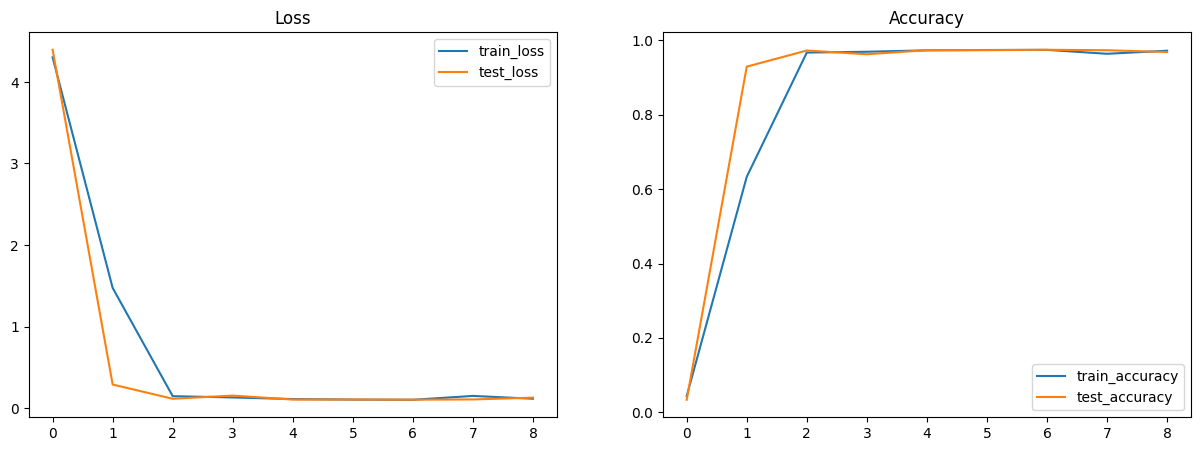

<Figure size 640x480 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [35]:

logits = fin_model.apply(fin_params, xb)
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

4.6910295


In [36]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)
            
#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)

        
#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx

In [37]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context)
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

/opt/conda/lib/python3.10/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [38]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 53, 56, 1, 51, 43, 51, 43, 8, 0, 0, 21, 1, 52, 53, 52, 5, 1, 46, 39, 63, 1, 60, 47, 60, 43, 56, 43, 57, 2, 0, 31, 59, 50, 42, 0, 13, 58, 1, 21, 56, 43, 1, 39, 52, 57, 1, 39, 57, 43, 58, 1, 43, 44, 1, 59, 54, 58, 43, 52, 58, 1, 63, 56, 1, 40, 59, 58, 8, 1, 35, 53, 53, 50, 1, 51, 39, 52, 57, 1, 53, 44, 58, 43, 1, 61, 53, 56, 58, 1, 58, 53, 43, 1, 39, 52, 42, 56, 50, 43, 56, 57, 43, 50, 40, 43, 39, 57, 1, 40, 53, 51, 43, 1, 40, 53, 59, 50, 42, 46, 39, 58, 46, 52, 1, 63, 53, 59, 1, 40, 43, 43, 57, 1, 43, 52, 1, 51, 43, 1, 58, 46, 47, 52, 10, 1, 47, 57, 10, 1, 31, 59, 41, 49, 51, 43, 1, 57, 39, 60, 47, 52, 60, 39, 52, 58, 1, 46, 39, 58, 1, 47, 57, 21, 1, 46, 39, 42, 1, 43, 56, 1, 51, 43, 43, 42, 1, 40, 59, 58, 43, 57, 43, 1, 58, 46, 43, 2, 0, 26, 47, 52, 0, 14, 43, 56, 58, 1, 51, 39, 52, 1, 39, 44, 1, 42, 43, 45, 56, 53, 59, 56, 57, 43, 1, 58, 50, 43, 39, 56, 56, 43, 6, 1, 53, 52, 56, 57, 1, 57, 54, 58, 39, 50, 43, 58, 1, 49, 54, 43, 42, 1, 53, 53, 46, 59, 1, 57, 59, 47, 56, 42, 6, 1, 

In [39]:
print(decode(token_gen))

Lor meme.

I non' hay viveres!
Suld
At Ire ans aset ef uptent yr but. Wool mans ofte wort toe andrlerselbeas bome bouldhathn you bees en me thin: is: Suckme savinvant hat isI had er meed butese the!
Nin
Bert man af degrourse tlearre, onrs sptalet kped oohu suird, nof prer th tharr beldeat bugpad ber yourt yot he ds, a heey ded mam,
Gy bee trafI at of noteed, wrce, he tham attes thioherron?

Thar, whe my yohd then,
Urr aOd, soy now It. LAMurn you yotleer nat wet shere my ste?
Om ris.

Yut sensm me,
Wupter henons,
Ghais then you k birs nrly:
Nhe mar the lou ah, ho. Nhds tef a pongn
Hees, bur whe hon anrrf hersUhis weat sus, non geleres wet' pas:
Wpy
The entuntes
Whel whiser sp?

Ris yount nold ste nohe so mle yo to cusawe the weamenb notfhs Tort, meerderetf to is states.

Yece.

Ig, The whid,, hohe leceng toalt the wour es but
An heiof wheito,
Roy fO he thenise a aar, tetar foruve hat def we ence ret bemes best hale hy nou pk end?
Wis san bendy me  d'et wourunte moun is tewb afed?

B's h

In [40]:
att_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=4,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=256,
    block_size=64,
)

var_params = att_model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

Total number of parameters: 2_289_089


In [41]:
jax.random.categorical(jax.random.PRNGKey(100), jnp.array([10.0,-10.0,-10.0,10.0,-11.0,-11.0,-11.0,-100.0,-1000]))

Array(3, dtype=int32)

In [42]:
logitss = state.apply_fn({'params': state.params}, (43*jnp.zeros((1,1))).astype(jnp.int32))[:,-1,:]

In [43]:
token_gen[:,-32:]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
print("gen text: ",print(decode(token_gen[0].tolist())), "end of text")

In [ ]:
jax.random.randint(jax.random.PRNGKey(52), (1,32), minval, maxval

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np

logitss = state.apply_fn({'params': state.params}, xbb[0].reshape(1,32))[:,-1,:]

probs = F.softmax(torch.from_numpy(np.asarray(logitss)), dim=-1) # (B, C)
# sample from the distribution
idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
idx_next

In [ ]:
state.tx.